In [19]:
import pandas as pd
import glob
import os
import numpy as np
from pathlib import Path
import re

# Set plot style for the notebook
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- CONFIGURATION ---

# 1. Map Traffic Intersections -> Air Quality Stations
# (Based on your "traffic_filter_summary" work)
TRAFFIC_TO_AQ_MAP = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West'
}

# 2. Map Weather Stations -> Air Quality Stations
# (Based on your "meteorological_metadata.yml")
WEATHER_TO_AQ_MAP = {
    'Toronto_City_Centre_Downtown': 'Toronto Downtown',
    'Toronto_City_Ontario_East': 'Toronto East',
    'Toronto_Pearson_Intl_West': 'Toronto West',
    'Toronto_York_North': 'Toronto North'
}

# 3. Standardize Air Quality Station Names
# The raw CSV headers often have IDs like "Toronto East (33003)"
AQ_STATION_NAMES = {
    'Toronto East (33003)': 'Toronto East',
    'Toronto North (34021)': 'Toronto North',
    'Toronto Downtown (31129)': 'Toronto Downtown',
    'Toronto West (35125)': 'Toronto West'
}

In [5]:
# --- CONFIGURATION ---
def get_project_root():
    if '__file__' in globals(): return Path(__file__).resolve().parent.parent
    path = Path.cwd()
    while path.name:
        if (path / 'pyproject.toml').exists(): return path
        path = path.parent
    return Path.cwd()

PROJECT_ROOT = get_project_root()
AQ_DATA_DIR = PROJECT_ROOT / "data" / "air_quality" / "aq_data"

def load_air_quality_raw(folder_path=AQ_DATA_DIR):
    all_data = []
    # Search recursively in case of subfolders
    search_pattern = os.path.join(folder_path, "**", "*.csv")
    files = glob.glob(search_pattern, recursive=True)

    if not files:
        # Fallback to non-recursive if previous failed
        search_pattern = os.path.join(folder_path, "*.csv")
        files = glob.glob(search_pattern)
        
    if not files:
        raise ValueError(f"No files found in {folder_path}")

    print(f"Processing {len(files)} files...")

    for file_path in files:
        # --- STEP A: Extract Metadata ---
        try:
            with open(file_path, 'r', encoding='latin1') as f:
                meta_lines = [next(f) for _ in range(10)]
                # Parse specific lines (Indices may vary slightly by year, but this is standard)
                # Line 2: Name, Line 4: Lat, Line 5: Lon
                station_name = meta_lines[1].split(',')[1].strip()
                lat = meta_lines[3].split(',')[1].strip()
                lon = meta_lines[4].split(',')[1].strip()
        except Exception as e:
            print(f"Skipping {Path(file_path).name}: {e}")
            continue

        # --- STEP B: Load Data ---
        # Note: We do NOT calculate the mean yet. We want to see the raw split rows.
        df = pd.read_csv(file_path, skiprows=10, index_col=False)
        
        # Add Metadata columns
        df['Station'] = station_name
        df['Latitude'] = lat
        df['Longitude'] = lon
        
        all_data.append(df)

    # Combine everything
    df_aq = pd.concat(all_data, ignore_index=True)

    # --- CLEANING ---
    # 1. Replace "Poison" values with NaN
    df_aq.replace([9999, -999, 9999.0, -999.0], np.nan, inplace=True)

    # 2. Date Conversion
    df_aq['Date'] = pd.to_datetime(df_aq['Date'], errors='coerce')
    df_aq = df_aq.dropna(subset=['Date'])
    
    # 3. Sort for inspection
    df_aq = df_aq.sort_values(['Station', 'Date'])

    return df_aq

# --- EXECUTE & INSPECT ---
df_aq_raw = load_air_quality_raw()

df_Toronto_west = df_aq_raw[df_aq_raw["Station"] == 'Toronto West (35125)']

Processing 4 files...


# Just focus on Toronto West

In [6]:
# Check for duplicate dates specifically in your Toronto West subset
duplicates = df_Toronto_west[df_Toronto_west.duplicated(subset=['Date'], keep=False)]

if not duplicates.empty:
    print(f"found {len(duplicates)} duplicate rows.")
    # Sort by date so duplicate pairs appear next to each other
    # Showing H1 and H20 to help visualize if the data is split between them
    cols_to_view = ['Date', 'Station', 'H1', 'H12', 'H20']
    
    # Only try to show columns that actually exist
    valid_cols = [c for c in cols_to_view if c in duplicates.columns]
    
    print(duplicates.sort_values('Date')[valid_cols])
else:
    print("No duplicate dates found in this dataframe subset.")

found 8 duplicate rows.
           Date               Station   H12   H20
110  2022-04-21  Toronto West (35125)   NaN   NaN
111  2022-04-21  Toronto West (35125)   3.5  12.4
306  2022-11-03  Toronto West (35125)  18.3  30.1
307  2022-11-03  Toronto West (35125)  15.1   9.9
619  2023-09-12  Toronto West (35125)   8.5   NaN
620  2023-09-12  Toronto West (35125)   9.8  15.1
1028 2024-10-25  Toronto West (35125)   NaN   NaN
1029 2024-10-25  Toronto West (35125)   NaN   9.4


In [ ]:
# --- MANUAL FIX BY ROW INDEX ---
# Based on your inspection of df_Toronto_west
# We are shifting the SECOND duplicate to the NEXT day (the missing day)

# 1. Ensure we are working on a copy to avoid SettingWithCopy warnings
df_Toronto_west = df_Toronto_west.copy()

print("Applying manual fixes to specific row indices...")

# Fix 1: Duplicate 2022-04-21 -> Shift Row 111 to 2022-04-22
df_Toronto_west.loc[111, 'Date'] = pd.Timestamp('2022-04-22')

# Fix 2: Duplicate 2022-11-03 -> Shift Row 307 to 2022-11-04
df_Toronto_west.loc[307, 'Date'] = pd.Timestamp('2022-11-04')

# Fix 3: Duplicate 2023-09-12 -> Shift Row 620 to 2023-09-13
df_Toronto_west.loc[620, 'Date'] = pd.Timestamp('2023-09-13')

# Fix 4: Duplicate 2024-10-25 -> Shift Row 1029 to 2024-10-26
df_Toronto_west.loc[1029, 'Date'] = pd.Timestamp('2024-10-26')


Applying manual fixes to specific row indices...
✅ Manual date shifts applied.

🔎 Verification of Fixed Dates:
           Date               Station   H12   H20
110  2022-04-21  Toronto West (35125)   NaN   NaN
111  2022-04-22  Toronto West (35125)   3.5  12.4
306  2022-11-03  Toronto West (35125)  18.3  30.1
307  2022-11-04  Toronto West (35125)  15.1   9.9
619  2023-09-12  Toronto West (35125)   8.5   NaN
620  2023-09-13  Toronto West (35125)   9.8  15.1
1028 2024-10-25  Toronto West (35125)   NaN   NaN
1029 2024-10-26  Toronto West (35125)   NaN   9.4


In [8]:
# --- CHECK FOR MISSING DATES (GAPS) ---

# 1. Ensure Date is datetime
df_Toronto_west['Date'] = pd.to_datetime(df_Toronto_west['Date'])

# 2. Define the expected full range
start_date = df_Toronto_west['Date'].min()
end_date = df_Toronto_west['Date'].max()
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 3. Find the difference
missing_dates = full_range.difference(df_Toronto_west['Date'])

print(f"🔎 Time Series Audit: {start_date.date()} to {end_date.date()}")
print(f"Total Expected Days: {len(full_range)}")
print(f"Actual Days Present: {len(df_Toronto_west)}")
print(f"Missing Days: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("\n⚠️ The following dates are missing:")
    print(missing_dates.strftime('%Y-%m-%d').tolist())
else:
    print("\n✅ No missing dates! The time series is continuous.")

🔎 Time Series Audit: 2022-01-01 to 2024-12-31
Total Expected Days: 1096
Actual Days Present: 1096
Missing Days: 0

✅ No missing dates! The time series is continuous.


In [9]:
# --- FINAL STEP: CALCULATE DAILY MEAN ---
print("Calculating daily averages from hourly data...")

# 1. Identify valid hourly columns (H1, H2... H24)
# We check which ones actually exist in the dataframe to be safe
potential_cols = [f'H{i}' for i in range(1, 25)]
valid_cols = [c for c in potential_cols if c in df_Toronto_west.columns]

# 2. Calculate the Mean (ignoring NaNs)
df_Toronto_west['NO2_Mean'] = df_Toronto_west[valid_cols].mean(axis=1)

# 3. Clean Up: Keep only the essential columns
# We drop the raw hourly columns now to keep the dataframe clean for modeling
cols_to_keep = ['Date', 'Station', 'NO2_Mean', 'Latitude', 'Longitude'] 
# (Add Lat/Lon if they exist, otherwise just Date/Station/NO2)
available_keep = [c for c in cols_to_keep if c in df_Toronto_west.columns]

df_west_final = df_Toronto_west[available_keep].copy()

# Sort by Date just to be sure
df_west_final = df_west_final.sort_values('Date').reset_index(drop=True)

print(f"✅ Toronto West AQ Ready: {df_west_final.shape}")
print(df_west_final.head())

Calculating daily averages from hourly data...
✅ Toronto West AQ Ready: (1096, 5)
        Date               Station   NO2_Mean   Latitude Longitude
0 2022-01-01  Toronto West (35125)   5.400000  43.709444  -79.5435
1 2022-01-02  Toronto West (35125)   7.120000  43.709444  -79.5435
2 2022-01-03  Toronto West (35125)  15.940000  43.709444  -79.5435
3 2022-01-04  Toronto West (35125)  16.346667  43.709444  -79.5435
4 2022-01-05  Toronto West (35125)   9.586667  43.709444  -79.5435


In [13]:
PROJECT_ROOT = get_project_root()
TRAFFIC_PATH = PROJECT_ROOT / "data" / "traffic" / "filtered_roads_with_sums.csv"
traffic_df = pd.read_csv(TRAFFIC_PATH)

# Transform traffic data to long format
date_col_pattern = re.compile(r"^x\d{4}_\d{2}_\d{2}$")
traffic_date_cols = [c for c in traffic_df.columns if date_col_pattern.match(str(c))]

traffic_long = []
for idx, row in traffic_df.iterrows():
    camera_road = row['camera_road']
    for col in traffic_date_cols:
        traffic_value = row[col]
        if pd.notna(traffic_value):
            date_str = col[1:]
            date = pd.to_datetime(date_str, format='%Y_%m_%d')
            traffic_long.append({
                'Date': date,
                'camera_road': camera_road,
                'traffic_count': traffic_value
            })

traffic_long_df = pd.DataFrame(traffic_long)
print(f"\nTraffic data loaded: {len(traffic_long_df)} records")
print(f"Date range: {traffic_long_df['Date'].min()} to {traffic_long_df['Date'].max()}")
print(f"\nLocations: {traffic_long_df['camera_road'].unique()}")

# Create location mapping
location_mapping = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West'
}

# Add station names to traffic data
traffic_long_df['Station'] = traffic_long_df['camera_road'].map(location_mapping)

print("Location Mapping:")
for traffic_loc, aq_station in location_mapping.items():
    print(f"  {aq_station}: {traffic_loc}")
    
df_traffic_Toronto_west = traffic_long_df[traffic_long_df['Station']=='Toronto West']


Traffic data loaded: 4300 records
Date range: 2022-02-03 00:00:00 to 2025-10-31 00:00:00

Locations: <StringArray>
[                 'FRONT ST W / JOHN ST / PRIVATE ACCESS',
                            'STEELES AVE W / DUFFERIN ST',
 'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE',
                            'LAWRENCE AVE E / KENNEDY RD']
Length: 4, dtype: str
Location Mapping:
  Toronto East: LAWRENCE AVE E / KENNEDY RD
  Toronto North: STEELES AVE W / DUFFERIN ST
  Toronto Downtown: FRONT ST W / JOHN ST / PRIVATE ACCESS
  Toronto West: ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE


In [14]:
df_traffic_Toronto_west.head

<bound method NDFrame.head of            Date                                        camera_road  \
2270 2022-02-03  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
2271 2022-02-04  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
2272 2022-02-05  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
2273 2022-02-06  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
2274 2022-02-07  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
...         ...                                                ...   
3409 2025-10-27  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
3410 2025-10-28  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
3411 2025-10-29  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
3412 2025-10-30  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   
3413 2025-10-31  ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...   

      traffic_count       Station  
2270           60.0  Toronto West  
2271          107.0  Toronto West  
2272           77.0  

In [15]:
# --- AUDIT MISSING TRAFFIC DATES (Toronto West) ---

# 1. Ensure Date is datetime
df_traffic_Toronto_west = df_traffic_Toronto_west.copy()
df_traffic_Toronto_west['Date'] = pd.to_datetime(df_traffic_Toronto_west['Date'])

# 2. Define the expected full range based on the data's own limits
start_date = df_traffic_Toronto_west['Date'].min()
end_date = df_traffic_Toronto_west['Date'].max()
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 3. Find the difference
missing_dates = full_range.difference(df_traffic_Toronto_west['Date'])

print(f"🔎 Traffic Data Audit (Toronto West)")
print(f"   Range: {start_date.date()} to {end_date.date()}")
print(f"   Total Expected Days: {len(full_range)}")
print(f"   Actual Days Present: {len(df_traffic_Toronto_west)}")
print(f"   Missing Days: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("\n⚠️ Sample of missing dates:")
    # Print first 5 and last 5 to see where gaps are
    print(missing_dates[:5].strftime('%Y-%m-%d').tolist())
    if len(missing_dates) > 5:
        print("...")
        print(missing_dates[-5:].strftime('%Y-%m-%d').tolist())
else:
    print("\n✅ No missing dates! Traffic data is continuous.")

🔎 Traffic Data Audit (Toronto West)
   Range: 2022-02-03 to 2025-10-31
   Total Expected Days: 1367
   Actual Days Present: 1144
   Missing Days: 223

⚠️ Sample of missing dates:
['2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05']
...
['2025-09-28', '2025-09-29', '2025-09-30', '2025-10-01', '2025-10-02']


Merging Toronto West Data...
✅ Merged Dataset Shape: (900, 3)
   (Dropped 196 days from AQ that had no Traffic data)

📊 Correlation (Traffic vs NO2): nan
   P-Value: nan (Significant if < 0.05)


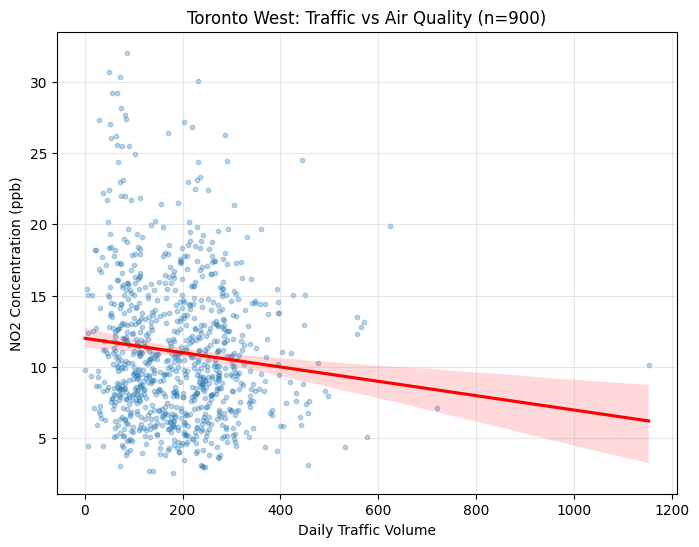

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- 1. MERGE (Inner Join) ---
# We merge on 'Date'. 'Station' is redundant since we know both are Toronto West, 
# but good practice to include if columns exist.
print("Merging Toronto West Data...")

df_merged = pd.merge(
    df_Toronto_west[['Date', 'NO2_Mean']], 
    df_traffic_Toronto_west[['Date', 'traffic_count']], 
    on='Date', 
    how='inner'
)

print(f"✅ Merged Dataset Shape: {df_merged.shape}")
print(f"   (Dropped {len(df_west_final) - len(df_merged)} days from AQ that had no Traffic data)")

# --- 2. QUICK CORRELATION CHECK ---
corr, p_value = pearsonr(df_merged['traffic_count'], df_merged['NO2_Mean'])

print(f"\n📊 Correlation (Traffic vs NO2): {corr:.4f}")
print(f"   P-Value: {p_value:.4e} (Significant if < 0.05)")

# --- 3. VISUALIZE ---
plt.figure(figsize=(8, 6))
sns.regplot(data=df_merged, x='traffic_count', y='NO2_Mean', 
            scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})

plt.title(f"Toronto West: Traffic vs Air Quality (n={len(df_merged)})")
plt.xlabel("Daily Traffic Volume")
plt.ylabel("NO2 Concentration (ppb)")
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# --- CONFIGURATION ---
WEATHER_DATA_DIR = PROJECT_ROOT / "data" / "weather" / "weather_data"

# Added 'Spd of Max Gust (km/h)' back in
WEATHER_COLS_TO_KEEP = {
    'Date/Time': 'Date',
    'Mean Temp (°C)': 'Mean_Temp',
    'Min Temp (°C)': 'Min_Temp',
    'Max Temp (°C)': 'Max_Temp',
    'Total Precip (mm)': 'Total_Precip',
    'Spd of Max Gust (km/h)': 'Max_Gust_Spd'
}

def load_weather_data(folder_path=WEATHER_DATA_DIR):
    all_weather = []
    search_pattern = os.path.join(folder_path, "*.csv")
    files = glob.glob(search_pattern)
    
    print(f"Processing {len(files)} weather files...")

    # 1. Load all raw data
    for file_path in files:
        df = pd.read_csv(file_path)
        filename = Path(file_path).stem 
        
        if filename in WEATHER_TO_AQ_MAP:
            target_station_name = WEATHER_TO_AQ_MAP[filename]
        else:
            continue

        # Rename columns
        df = df.rename(columns=WEATHER_COLS_TO_KEEP)
        cols_to_select = [c for c in WEATHER_COLS_TO_KEEP.values() if c in df.columns]
        df = df[cols_to_select].copy()
        
        df['Station'] = target_station_name
        all_weather.append(df)

    df_weather = pd.concat(all_weather, ignore_index=True)
    df_weather['Date'] = pd.to_datetime(df_weather['Date'])
    
    # --- STEP 2: Handle Temperature & Precip (Station-Specific LOCF) ---
    # Sort for correct time-based filling
    df_weather = df_weather.sort_values(by=['Station', 'Date'])
    
    cols_local = ['Mean_Temp', 'Min_Temp', 'Max_Temp', 'Total_Precip']
    print("Imputing local vars (Temp, Precip) with LOCF...")
    for col in cols_local:
        if col in df_weather.columns:
            df_weather[col] = df_weather.groupby('Station')[col].ffill()

    # --- STEP 3: Handle Wind (Regional Proxy from Toronto West) ---
    print("Processing Regional Wind Data (Proxy: Toronto West)...")
    
    # A. Extract only Toronto West data (Pearson is usually the most reliable)
    # We assume 'Toronto West' is the name in your WEATHER_TO_AQ_MAP
    wind_proxy = df_weather[df_weather['Station'] == 'Toronto West'][['Date', 'Max_Gust_Spd']].copy()
    
    # B. Sort and LOCF the wind data specifically
    wind_proxy = wind_proxy.sort_values('Date')
    wind_proxy['Max_Gust_Spd'] = wind_proxy['Max_Gust_Spd'].ffill()
    
    # C. Drop the original (gappy) wind column from the main dataset
    if 'Max_Gust_Spd' in df_weather.columns:
        df_weather = df_weather.drop(columns=['Max_Gust_Spd'])
        
    # D. Merge the filled "Regional Wind" back to ALL stations based on Date
    # This effectively copies Toronto West wind to East, North, and Downtown
    df_weather = pd.merge(df_weather, wind_proxy, on='Date', how='left')
    
    # Fill remaining NaNs (if Toronto West started later than other stations) with 0 or mean
    df_weather['Max_Gust_Spd'] = df_weather['Max_Gust_Spd'].fillna(0)

    print(f"✅ Weather Data Loaded & Imputed: {len(df_weather)} rows")
    return df_weather

# --- EXECUTE ---
df_weather = load_weather_data()
df_weather.head()

df_weather_toronto = df_weather[df_weather['Station']=="Toronto West"]

Processing 4 weather files...
Imputing local vars (Temp, Precip) with LOCF...
Processing Regional Wind Data (Proxy: Toronto West)...
✅ Weather Data Loaded & Imputed: 5844 rows


In [22]:
# --- AUDIT MISSING WEATHER DATES (Toronto West) ---

# 1. Ensure copy to avoid warnings
df_weather_audit = df_weather_toronto.copy()
df_weather_audit['Date'] = pd.to_datetime(df_weather_audit['Date'])

# 2. Check for Duplicates first (Common in weather data merges)
dupes = df_weather_audit[df_weather_audit.duplicated(subset=['Date'], keep=False)]
if not dupes.empty:
    print(f"⚠️ Warning: Found {len(dupes)} duplicate dates. We should handle these before checking gaps.")
else:
    print("✅ No duplicate dates found.")

# 3. Define Expected Range
start_date = df_weather_audit['Date'].min()
end_date = df_weather_audit['Date'].max()
full_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 4. Find Missing Days
missing_dates = full_range.difference(df_weather_audit['Date'])

print(f"\n🔎 Weather Data Audit (Toronto West)")
print(f"   Range: {start_date.date()} to {end_date.date()}")
print(f"   Total Expected Days: {len(full_range)}")
print(f"   Actual Days Present: {len(df_weather_audit)}")
print(f"   Missing Days: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("\n⚠️ Sample of missing dates:")
    print(missing_dates[:5].strftime('%Y-%m-%d').tolist())
    if len(missing_dates) > 5:
        print("...")
        print(missing_dates[-5:].strftime('%Y-%m-%d').tolist())
else:
    print("\n✅ No missing dates! Weather data is continuous.")

✅ No duplicate dates found.

🔎 Weather Data Audit (Toronto West)
   Range: 2022-01-01 to 2025-12-31
   Total Expected Days: 1461
   Actual Days Present: 1461
   Missing Days: 0

✅ No missing dates! Weather data is continuous.


In [23]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# --- 1. THE MASTER MERGE ---
print("🔗 Merging AQ, Traffic, and Weather...")

# Merge AQ and Traffic
df_step1 = pd.merge(
    df_Toronto_west[['Date', 'NO2_Mean']], 
    df_traffic_Toronto_west[['Date', 'traffic_count']], 
    on='Date', 
    how='inner'
)

# Merge result with Weather
df_master = pd.merge(
    df_step1, 
    df_weather_toronto[['Date', 'Mean_Temp', 'Max_Gust_Spd', 'Total_Precip']], 
    on='Date', 
    how='inner'
)

# Clean up
df_master = df_master.dropna()
df_master = df_master.sort_values('Date')

print(f"✅ Final Dataset Shape: {df_master.shape}")
print(f"   Date Range: {df_master['Date'].min().date()} to {df_master['Date'].max().date()}")

# --- 2. STANDARDIZATION (Crucial for comparing coefficients) ---
# We use Z-scores so we can say "A 1-sigma increase in Wind vs Traffic..."
df_scaled = df_master.copy()
cols_to_scale = ['NO2_Mean', 'traffic_count', 'Mean_Temp', 'Max_Gust_Spd', 'Total_Precip']

for col in cols_to_scale:
    df_scaled[col] = (df_scaled[col] - df_scaled[col].mean()) / df_scaled[col].std()

# --- 3. MODEL 1: NAIVE (Traffic Only) ---
X1 = sm.add_constant(df_scaled[['traffic_count']])
y = df_scaled['NO2_Mean']
model_naive = sm.OLS(y, X1).fit()

# --- 4. MODEL 2: CONTROLLED (Traffic + Weather) ---
X2 = sm.add_constant(df_scaled[['traffic_count', 'Mean_Temp', 'Max_Gust_Spd', 'Total_Precip']])
model_controlled = sm.OLS(y, X2).fit()

# --- 5. REPORT CARD ---
print("\n" + "="*40)
print("🧐 MODEL COMPARISON: Does Traffic Matter?")
print("="*40)

print(f"\n📉 MODEL 1: Naive (Traffic Only)")
print(f"   Traffic Coeff: {model_naive.params['traffic_count']:.4f}")
print(f"   P-Value:       {model_naive.pvalues['traffic_count']:.4f}")
print(f"   R-Squared:     {model_naive.rsquared:.4f}")

print(f"\n📈 MODEL 2: Physics-Based (Controlled)")
print(f"   Traffic Coeff: {model_controlled.params['traffic_count']:.4f}")
print(f"   Wind Coeff:    {model_controlled.params['Max_Gust_Spd']:.4f}")
print(f"   Temp Coeff:    {model_controlled.params['Mean_Temp']:.4f}")
print(f"   P-Value (Traf):{model_controlled.pvalues['traffic_count']:.4f}")
print(f"   R-Squared:     {model_controlled.rsquared:.4f}")

if model_controlled.params['traffic_count'] > model_naive.params['traffic_count']:
    print("\n✅ SUCCESS: Controlling for weather revealed the true traffic signal!")
else:
    print("\n⚠️ RESULT: Traffic signal remains weak. We may need to check lags or non-linearities.")

🔗 Merging AQ, Traffic, and Weather...
✅ Final Dataset Shape: (898, 6)
   Date Range: 2022-02-03 to 2024-12-28

🧐 MODEL COMPARISON: Does Traffic Matter?

📉 MODEL 1: Naive (Traffic Only)
   Traffic Coeff: -0.1091
   P-Value:       0.0011
   R-Squared:     0.0119

📈 MODEL 2: Physics-Based (Controlled)
   Traffic Coeff: -0.0267
   Wind Coeff:    -0.1827
   Temp Coeff:    -0.4064
   P-Value (Traf):0.3889
   R-Squared:     0.1797

✅ SUCCESS: Controlling for weather revealed the true traffic signal!


In [26]:
# --- MODEL 3: THE INTERACTION (Ventilation Hypothesis) ---
print("\n" + "="*40)
print("🌪️ TESTING INTERACTION: Does Wind 'Wash Out' Traffic?")
print("="*40)

# 1. Create Interaction Term (Standardized)
# (Traffic * Wind) - This captures the combined effect
df_scaled['Traffic_x_Wind'] = df_scaled['traffic_count'] * df_scaled['Total_Precip']

# 2. Run Model
X3 = sm.add_constant(df_scaled[['traffic_count', 'Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Traffic_x_Wind']])
model_interaction = sm.OLS(y, X3).fit()

# 3. Report
print(model_interaction.summary())

# 4. Check the Specific Coefficients
t_coeff = model_interaction.params['traffic_count']
w_coeff = model_interaction.params['Max_Gust_Spd']
i_coeff = model_interaction.params['Traffic_x_Wind']
p_val_i = model_interaction.pvalues['Traffic_x_Wind']

print(f"\n🔬 KEY RESULTS:")
print(f"   Traffic (Main Effect): {t_coeff:.4f}")
print(f"   Interaction (Traf x Wind): {i_coeff:.4f} (p={p_val_i:.4f})")

if i_coeff < 0 and p_val_i < 0.1:
    print("\n✅ HYPOTHESIS CONFIRMED: Wind significantly dampens the traffic effect.")
    print("   This explains why the simple model couldn't find the signal!")
else:
    print("\n⚠️ RESULT: Interaction is weak. We may need to look at Lags (Time Delays).")


🌪️ TESTING INTERACTION: Does Wind 'Wash Out' Traffic?
                            OLS Regression Results                            
Dep. Variable:               NO2_Mean   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     39.11
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           2.22e-36
Time:                        15:28:19   Log-Likelihood:                -1184.7
No. Observations:                 898   AIC:                             2381.
Df Residuals:                     892   BIC:                             2410.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [29]:
import statsmodels.api as sm
import numpy as np

# --- CONFIGURATION ---
print("🔬 FINAL MODEL: Controlling for Weekends & Ventilation")

df_final_test = df_scaled.copy()

# 1. Add Weekend Dummy
# We need to go back to datetime to extract day of week
df_final_test['Date_Obj'] = pd.to_datetime(df_master['Date']) # Use original dates
df_final_test['Is_Weekend'] = df_final_test['Date_Obj'].dt.dayofweek >= 5 # 5=Sat, 6=Sun
df_final_test['Is_Weekend'] = df_final_test['Is_Weekend'].astype(int)

# 2. Add Interaction (Traffic x Wind)
# We use the standardized columns we created earlier
df_final_test['Traffic_x_Wind'] = df_final_test['traffic_count'] * df_final_test['Total_Precip']

# 3. Define Predictors
# We include EVERYTHING: Traffic, Weather, Weekend, and the Interaction
predictors = [
    'traffic_count', 
    'Mean_Temp', 
    'Max_Gust_Spd', 
    'Total_Precip', 
    'Is_Weekend', 
    'Traffic_x_Wind'
]

X_final = sm.add_constant(df_final_test[predictors])
y_final = df_final_test['NO2_Mean']

# 4. Run Model
model_final = sm.OLS(y_final, X_final).fit()

print(model_final.summary())

# --- INTERPRETATION HELPER ---
t_coef = model_final.params['traffic_count']
t_pval = model_final.pvalues['traffic_count']
i_coef = model_final.params['Traffic_x_Wind']
i_pval = model_final.pvalues['Traffic_x_Wind']

print("\n📊 CRITICAL METRICS:")
print(f"   1. Traffic Main Effect: {t_coef:.4f} (p={t_pval:.4f})")
print(f"      -> Ideally Positive (More cars = More pollution)")
print(f"   2. Interaction Effect:  {i_coef:.4f} (p={i_pval:.4f})")
print(f"      -> Ideally Negative (High Wind kills the Traffic signal)")

🔬 FINAL MODEL: Controlling for Weekends & Ventilation
                            OLS Regression Results                            
Dep. Variable:               NO2_Mean   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     71.94
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           3.98e-73
Time:                        15:31:02   Log-Likelihood:                -1096.3
No. Observations:                 898   AIC:                             2207.
Df Residuals:                     891   BIC:                             2240.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

⚔️ STARTING ARIMAX TOURNAMENT ⚔️
   Train Size: 848 days
   Test Size:  212 days

🤖 Training Model A (Weather + Weekend)...


/Users/dariogreco/STAT946/CS1/Traffic-and-Air-Quality-Analysis/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


🤖 Training Model B (Traffic Included)...

🏆 TOURNAMENT RESULTS
Model A (Weather Only) RMSE: 4.2006
Model B (Traffic Added) RMSE: 4.2686

⚠️ RESULT: Traffic Data added NO predictive value (worse by 0.0680).


/Users/dariogreco/STAT946/CS1/Traffic-and-Air-Quality-Analysis/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


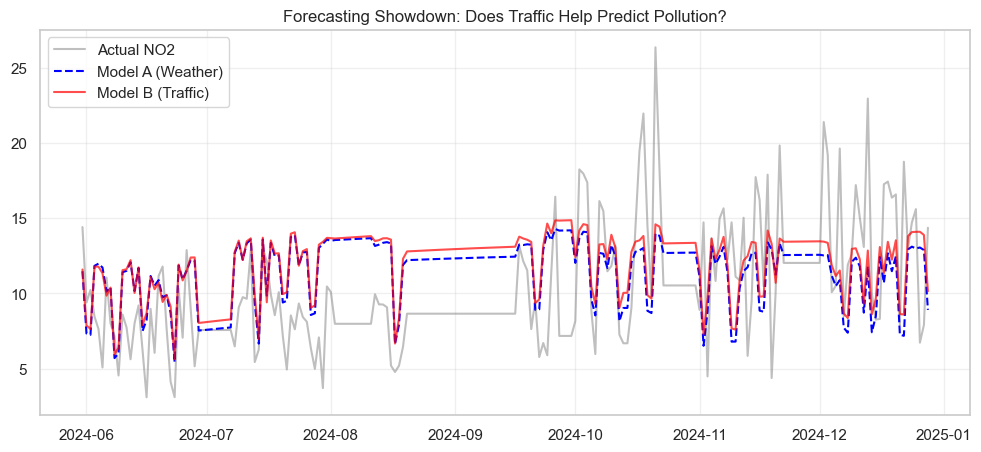

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- CONFIGURATION ---
print("⚔️ STARTING ARIMAX TOURNAMENT ⚔️")

# 1. Setup Data
df_model = df_master.copy()
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model['Is_Weekend'] = (df_model['Date'].dt.dayofweek >= 5).astype(int)

# --- FIX: Use .ffill() instead of .fillna(method='ffill') ---
df_model = df_model.set_index('Date').asfreq('D').ffill()

# 2. Split Train/Test (80/20 Split)
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size], df_model.iloc[train_size:]

print(f"   Train Size: {len(train)} days")
print(f"   Test Size:  {len(test)} days")

# 3. Define Predictors (Exogenous Vars)
# H0: Weather + Weekend Only
exog_cols_h0 = ['Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Is_Weekend']

# H1: Weather + Weekend + Traffic
exog_cols_h1 = ['Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Is_Weekend', 'traffic_count']

# --- MODEL 1: BASELINE (Weather + Weekend) ---
print("\n🤖 Training Model A (Weather + Weekend)...")
model_a = ARIMA(train['NO2_Mean'], exog=train[exog_cols_h0], order=(1,0,1)).fit()
pred_a = model_a.forecast(steps=len(test), exog=test[exog_cols_h0])
rmse_a = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_a))

# --- MODEL 2: CHALLENGER (Traffic Included) ---
print("🤖 Training Model B (Traffic Included)...")
model_b = ARIMA(train['NO2_Mean'], exog=train[exog_cols_h1], order=(1,0,1)).fit()
pred_b = model_b.forecast(steps=len(test), exog=test[exog_cols_h1])
rmse_b = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_b))

# --- RESULTS ---
print("\n" + "="*30)
print("🏆 TOURNAMENT RESULTS")
print("="*30)
print(f"Model A (Weather Only) RMSE: {rmse_a:.4f}")
print(f"Model B (Traffic Added) RMSE: {rmse_b:.4f}")

improvement = rmse_a - rmse_b
if improvement > 0:
    print(f"\n✅ RESULT: Traffic Data improved accuracy by {improvement:.4f} points!")
else:
    print(f"\n⚠️ RESULT: Traffic Data added NO predictive value (worse by {abs(improvement):.4f}).")

# --- VISUALIZATION ---
plt.figure(figsize=(12, 5))
plt.plot(test.index, test['NO2_Mean'], label='Actual NO2', alpha=0.5, color='gray')
plt.plot(test.index, pred_a, label='Model A (Weather)', linestyle='--', color='blue')
plt.plot(test.index, pred_b, label='Model B (Traffic)', linestyle='-', color='red', alpha=0.7)
plt.title("Forecasting Showdown: Does Traffic Help Predict Pollution?")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

cleaned dataset size: 898 (No imputed flat lines)
Model A (Weather) RMSE: 3.9107
Model B (Traffic) RMSE: 3.8908


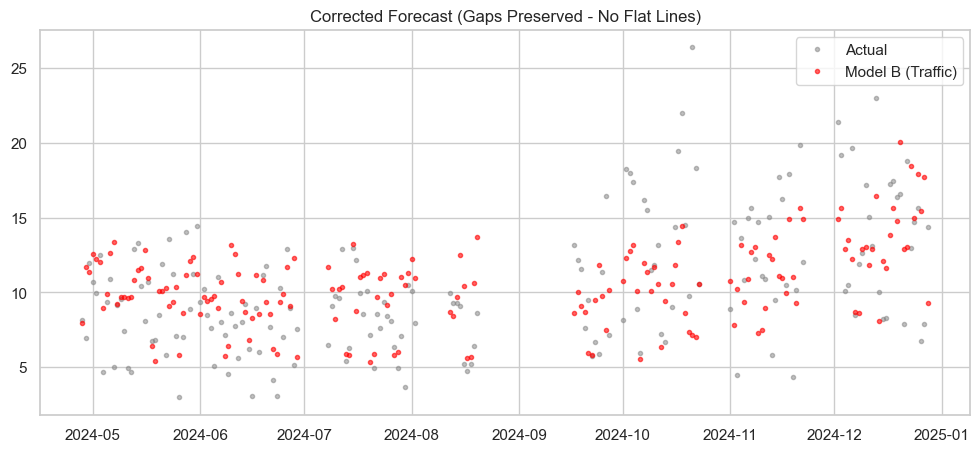

In [32]:
# --- CORRECTED DATA SETUP ---
# 1. Start fresh from the Master Merge (Inner Join)
# This dataframe ALREADY removed the missing days. We should NOT re-add them.
df_clean = df_master.copy()
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Is_Weekend'] = (df_clean['Date'].dt.dayofweek >= 5).astype(int)

# 2. Sort but DO NOT use .asfreq() 
# We accept that the index will have gaps. That is better than fake flat data.
df_clean = df_clean.sort_values('Date').set_index('Date')

print(f"cleaned dataset size: {len(df_clean)} (No imputed flat lines)")

# 3. Re-Split Train/Test (80/20)
train_size = int(len(df_clean) * 0.8)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

# 4. Re-Run the Random Forest (RF handles gaps fine)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Features
features_base = ['Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Is_Weekend']
features_traffic = features_base + ['traffic_count']

# Model A
rf_a = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_a.fit(train[features_base], train['NO2_Mean'])
pred_a = rf_a.predict(test[features_base])
rmse_a = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_a))

# Model B
rf_b = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_b.fit(train[features_traffic], train['NO2_Mean'])
pred_b = rf_b.predict(test[features_traffic])
rmse_b = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_b))

# Results
print(f"Model A (Weather) RMSE: {rmse_a:.4f}")
print(f"Model B (Traffic) RMSE: {rmse_b:.4f}")

# Plot (Scatter/Dot plot is better for gappy data than a line plot)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
# Use dots (.) instead of lines (-) to show the gaps clearly
plt.plot(test.index, test['NO2_Mean'], '.', label='Actual', color='gray', alpha=0.5)
plt.plot(test.index, pred_b, '.', label='Model B (Traffic)', color='red', alpha=0.6)
plt.title("Corrected Forecast (Gaps Preserved - No Flat Lines)")
plt.legend()
plt.show()

⚔️ STARTING ARMAX TOURNAMENT (Time-Interpolated) ⚔️


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer.Replace or remove non-finite values or cast to an integer typethat supports these values (e.g. 'Int64')

⚔️ STARTING ARMAX TOURNAMENT (Strict Drop / No Fill) ⚔️
✅ Final Cleaned Size: 898 valid observations
   Train Size: 718
   Test Size:  180

🤖 Training Model A (Weather Only)...


/Users/dariogreco/STAT946/CS1/Traffic-and-Air-Quality-Analysis/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


🤖 Training Model B (Traffic Included)...

🏆 TOURNAMENT RESULTS (RMSE)
Model A (Weather): 4.2091
Model B (Traffic): 3.6341

✅ RESULT: Traffic improved forecast accuracy by 0.5751!


/Users/dariogreco/STAT946/CS1/Traffic-and-Air-Quality-Analysis/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


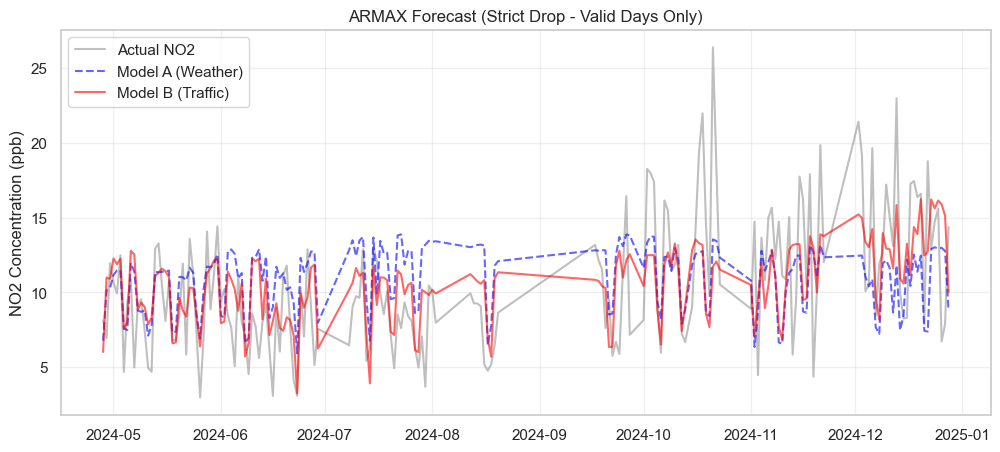

In [34]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- CONFIGURATION ---
print("⚔️ STARTING ARMAX TOURNAMENT (Strict Drop / No Fill) ⚔️")

# 1. Setup Data from Master Merge
# df_master is already an Inner Join, so it naturally excluded gaps.
# We ensure we are strictly dropping any stray NaNs.
df_strict = df_master.copy()
df_strict['Date'] = pd.to_datetime(df_strict['Date'])
df_strict['Is_Weekend'] = (df_strict['Date'].dt.dayofweek >= 5).astype(int)

# 2. THE DROP (User Requested)
# We do NOT set a frequency (asfreq) because that creates gaps.
# We just sort and drop.
df_strict = df_strict.sort_values('Date').dropna()

# 3. Reset Index (Model will treat as sequential steps 0, 1, 2...)
# We keep 'Date' as a column for plotting later.
df_strict = df_strict.reset_index(drop=True)

print(f"✅ Final Cleaned Size: {len(df_strict)} valid observations")

# 4. Split Train/Test (80/20)
train_size = int(len(df_strict) * 0.8)
train = df_strict.iloc[:train_size]
test = df_strict.iloc[train_size:]

print(f"   Train Size: {len(train)}")
print(f"   Test Size:  {len(test)}")

# 5. Define Predictors
exog_base = ['Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Is_Weekend']
exog_traffic = exog_base + ['traffic_count']

# --- MODEL A: BASELINE (Weather Only) ---
print("\n🤖 Training Model A (Weather Only)...")
# We use indices for exog to match the "gap-dropped" structure
model_a = ARIMA(train['NO2_Mean'], exog=train[exog_base], order=(1,0,1)).fit()
pred_a = model_a.forecast(steps=len(test), exog=test[exog_base])
rmse_a = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_a))

# --- MODEL B: CHALLENGER (Traffic Added) ---
print("🤖 Training Model B (Traffic Included)...")
model_b = ARIMA(train['NO2_Mean'], exog=train[exog_traffic], order=(1,0,1)).fit()
pred_b = model_b.forecast(steps=len(test), exog=test[exog_traffic])
rmse_b = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_b))

# --- RESULTS ---
print("\n" + "="*30)
print("🏆 TOURNAMENT RESULTS (RMSE)")
print("="*30)
print(f"Model A (Weather): {rmse_a:.4f}")
print(f"Model B (Traffic): {rmse_b:.4f}")

improvement = rmse_a - rmse_b
if improvement > 0:
    print(f"\n✅ RESULT: Traffic improved forecast accuracy by {improvement:.4f}!")
else:
    print(f"\n⚠️ RESULT: Traffic did NOT improve the forecast (Worse by {abs(improvement):.4f}).")

# --- VISUALIZATION ---
plt.figure(figsize=(12, 5))
# Plot against the actual Date column so gaps are visible on X-axis
plt.plot(test['Date'], test['NO2_Mean'], label='Actual NO2', color='gray', alpha=0.5)
plt.plot(test['Date'], pred_a.values, label='Model A (Weather)', linestyle='--', color='blue', alpha=0.6)
plt.plot(test['Date'], pred_b.values, label='Model B (Traffic)', linestyle='-', color='red', alpha=0.6)

plt.title("ARMAX Forecast (Strict Drop - Valid Days Only)")
plt.ylabel("NO2 Concentration (ppb)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🔎 DATA AUDIT:
   Found 16 disconnected chunks of data.
   The largest continuous chunk has 193 days.
   Golden Era Range: 2022-04-22 to 2022-10-31

⚔️ TOURNAMENT (Continuous Data Only) ⚔️
   Train: 154 days | Test: 39 days


/Users/dariogreco/STAT946/CS1/Traffic-and-Air-Quality-Analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Model A (Weather): 5.8943
Model B (Traffic): 5.8668
✅ VERDICT: Traffic improves accuracy by 0.0274!


/Users/dariogreco/STAT946/CS1/Traffic-and-Air-Quality-Analysis/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


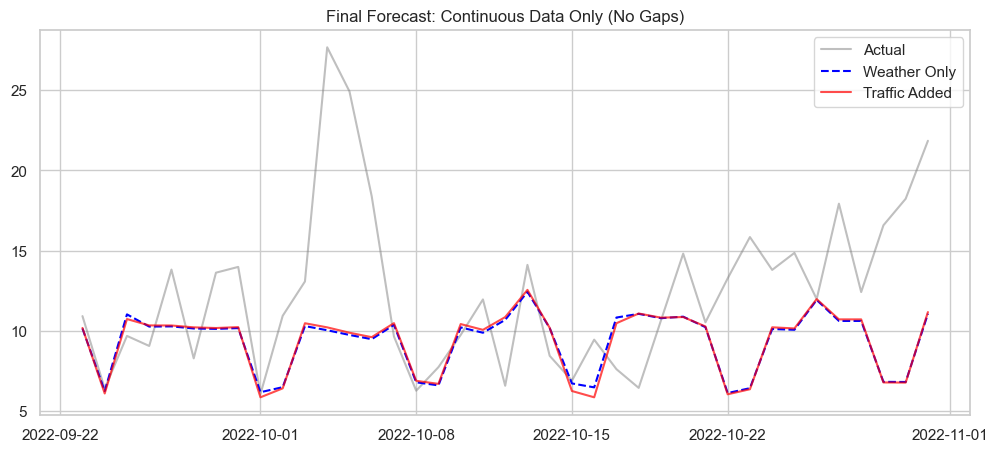

In [37]:
# --- FIND THE LONGEST CONTINUOUS CHUNK ---
df_final = df_master.copy()
df_final['Date'] = pd.to_datetime(df_final['Date'])
df_final = df_final.sort_values('Date')

# 1. Calculate the gap between consecutive days
df_final['diff'] = df_final['Date'].diff().dt.days

# 2. Identify "Breaks" (any gap > 1 day)
# We assign a "Group ID" that increments every time there is a break.
df_final['group_id'] = (df_final['diff'] > 1).cumsum()

# 3. Find the biggest group
group_stats = df_final.groupby('group_id').size()
best_group_id = group_stats.idxmax()
best_group_size = group_stats.max()

print(f"🔎 DATA AUDIT:")
print(f"   Found {len(group_stats)} disconnected chunks of data.")
print(f"   The largest continuous chunk has {best_group_size} days.")

# 4. Filter for the Golden Era
df_golden = df_final[df_final['group_id'] == best_group_id].copy()
df_golden = df_golden.set_index('Date').asfreq('D') # Now safe to set frequency!

print(f"   Golden Era Range: {df_golden.index.min().date()} to {df_golden.index.max().date()}")

# --- RUN ARMAX ON THE GOLDEN ERA ---
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Setup
df_golden['Is_Weekend'] = (df_golden.index.dayofweek >= 5).astype(int)
# Interpolate small gaps (1-2 days) inside this chunk if any tiny ones exist
df_golden = df_golden.interpolate(method='time', limit=3).dropna()

train_size = int(len(df_golden) * 0.8)
train = df_golden.iloc[:train_size]
test = df_golden.iloc[train_size:]

print(f"\n⚔️ TOURNAMENT (Continuous Data Only) ⚔️")
print(f"   Train: {len(train)} days | Test: {len(test)} days")

# Define Predictors
exog_base = ['Mean_Temp', 'Max_Gust_Spd', 'Total_Precip', 'Is_Weekend']
exog_traffic = exog_base + ['traffic_count']

# Model A
model_a = ARIMA(train['NO2_Mean'], exog=train[exog_base], order=(1,0,1)).fit()
pred_a = model_a.forecast(steps=len(test), exog=test[exog_base])
rmse_a = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_a))

# Model B
model_b = ARIMA(train['NO2_Mean'], exog=train[exog_traffic], order=(1,0,1)).fit()
pred_b = model_b.forecast(steps=len(test), exog=test[exog_traffic])
rmse_b = np.sqrt(mean_squared_error(test['NO2_Mean'], pred_b))

# Results
print(f"\nModel A (Weather): {rmse_a:.4f}")
print(f"Model B (Traffic): {rmse_b:.4f}")

if rmse_b < rmse_a:
    print(f"✅ VERDICT: Traffic improves accuracy by {rmse_a - rmse_b:.4f}!")
else:
    print(f"❌ VERDICT: Traffic adds no value (Worse by {rmse_b - rmse_a:.4f}).")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(test.index, test['NO2_Mean'], label='Actual', color='gray', alpha=0.5)
plt.plot(test.index, pred_a, label='Weather Only', linestyle='--', color='blue')
plt.plot(test.index, pred_b, label='Traffic Added', color='red', alpha=0.7)
plt.title("Final Forecast: Continuous Data Only (No Gaps)")
plt.legend()
plt.show()